# FullyStarNet

In this practice lesson we will learn to create and train a fully connected neural network for recognizing colored stars.

Input:
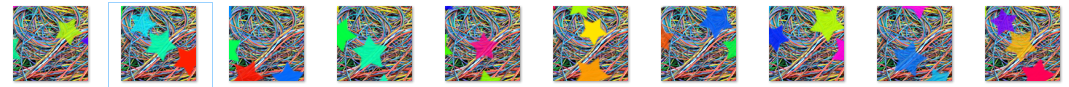
Output:
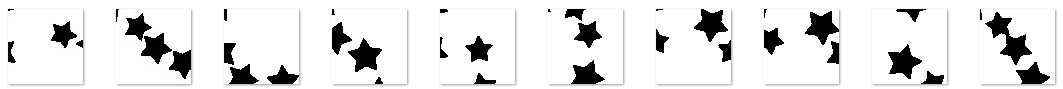

Our neural network should take some image data x and output some image data y whith the recognized stars. For training the network we use the star dataset given with this lecture

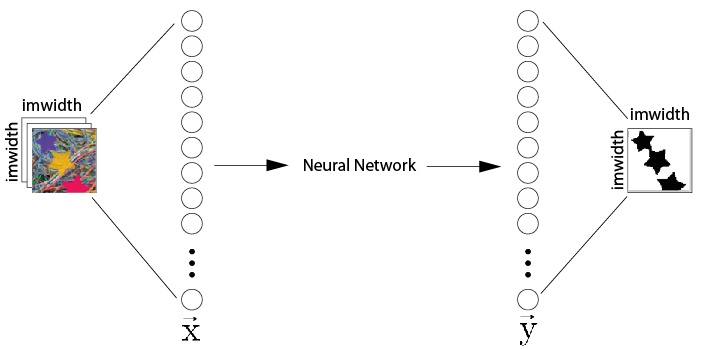

## We have to import some libraries and functions first.
Needed libraries are:
pillow, tensorflow, numpy, tqdm, matplotlib. Install with pip. For tensorflow check tensorflow website

In [ ]:
import os, platform, sys, glob, time
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import trange
import image_functions as imf
from datetime import datetime
tf.reset_default_graph() # reset Tensorboard

In [ ]:

###### Hyperparamter
learnrate = 0.0001    # Learning Rate
buffer_size = 1       # Buffer Size in data Pipeline, needed for loading big data from network
batchsize = 10        # Images per batch
ep_lim = 20           # Max number of epochs
imwidth = 20          # Image dimension used for training, smaller images computer faster 
                      # big impact on computation time, original image is 75x75
imf.imwidth = imwidth # Set width for imf (image functions)


## Lets start.
So what do we need again?

1. Prepare input data
2. Prepare datapipeline to get the data into the network
3. Define the network
4. Initialize all variables
5. Train the network 
6. Supervise the training



## 1. Input data
We search the folders containing the data and create two file list, one containing the x and one containing the y file paths


In [ ]:
#### Lisiting all Image files
x_path = "Sterne/x"
y_path = "Sterne/y"
file_list_x = []
file_list_y = []
file_list_x += sorted(glob.glob(x_path + "/**/*.png", recursive=True))
file_list_y += sorted(glob.glob(y_path + "/**/*.png", recursive=True))
print("Found ",len(file_list_x)," images")
assert len(file_list_x) == 2350 # If this line failes you did something wrong

## 2. Tensorflow Data Pipeline

Now we have a list of all files we will use for training our model, we have to get the data into our neural network. We can use tensorflow built in dataset class. It will automatically create a dataset from the file lists. It will apply some custom functions to every file to read the data from the file. First "imf.read_images" to read the image and "imf.create_stars_data" to reshape/resize the image in a way that we can work with it.
#### First we have to create the dataset

In [ ]:
# Creating tf constants containing the lists of file names
input_names = tf.constant(file_list_x)
label_names = tf.constant(file_list_y)

# Creating a Dataset-base from those file names
filenames = tf.data.Dataset.from_tensor_slices((input_names,label_names))

# Loading all image data into the dataset
dataset = filenames.map(imf.read_images, num_parallel_calls=4).repeat(ep_lim).apply(tf.contrib.data.map_and_batch(imf.create_stars_data, batchsize, num_parallel_batches=buffer_size, drop_remainder=True)).prefetch(buffer_size)

#### Now we have to create an iterator so we can iterate over the dataset

Iterators are used to navigate through the dataset. It represents the state of iterating through the dataset. Through the iterator we are able to load our images into the tensorflow graph.

In [ ]:
with tf.name_scope("Data_Pipeline"):
    #Creating the iterator from the dataset
    training_iterator = dataset.make_initializable_iterator()

    #Creating a placeholder where the iterator handle where the training_iterator can connect to.
    #The data will be pipied through #this handle
    handle = tf.placeholder(tf.string, shape=[])
    iterator = tf.data.Iterator.from_string_handle(handle, dataset.output_types, dataset.output_shapes)
    
    x, y_hat = iterator.get_next() ## Here we get our x and y_hat

## 3. + 4. Defining our Neural Network and initial values for all Variables
Now we can define our neural network. In this lesson we will only use fully connected layers, which, you know from the lecture, are basically just matrix mulitplications. Your weights and biases have to be of type tf.Variable so tensorflow can change those variables during training. The x data can be reached over the tensor "x" its dimensions are [batchsize,1,imwidth x imwidth x 3]. Usually matrix multiplications with 3d matricies are not possible, but tensorflow handles the third component "batchsize" automatically. The output of the network should be of dimensions [batchsize, 1, imwidth x imwidth].


The dimensions of our vector x is: 
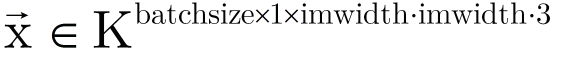

The dimensions of our vector y is: 
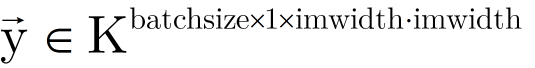

A fully connected layer can be represented by a matrix multiplication, where x is the input data into the layer, y is the output data, b the bias and f the acitavtion function of that layer:
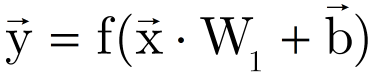


keep the dimensions correct!

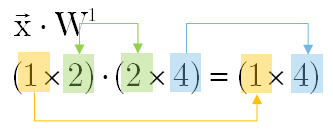

In [ ]:
with tf.name_scope("Network"):
    with tf.name_scope("Layer1"):
        w1 = tf.Variable(tf.random_normal([batchsize,imwidth*imwidth*3,500], mean = 0.0, stddev = 0.01))
        b1 = tf.Variable(tf.zeros([batchsize,1,500]))
        a1= tf.matmul(x,w1) 
        l1= tf.sigmoid(tf.add(a1,b1))
        tf.summary.histogram("Weights", w1)
        tf.summary.histogram("Bias", b1)
        
    with tf.name_scope("Layer2"):
        w2 = tf.Variable(tf.random_normal([batchsize,500,imwidth*imwidth], mean = 0.0, stddev = 0.01))
        b2 = tf.Variable(tf.zeros([batchsize,1,imwidth*imwidth]))
        a2 = tf.matmul(l1,w2)
        y = tf.sigmoid(tf.add(a2,b2))
        tf.summary.histogram("Weights", w1)
        tf.summary.histogram("Bias", b1)

### Defining Cost Function and Optimizer
We use the difference between the network output and the real image to calculate or cost/loss function. As an optimizier we choose the AdamOptimizer and tell it which function value to minimize

In [ ]:
with tf.name_scope("Cost"):
    cost = tf.reduce_mean(tf.square(y - y_hat))
    tf.summary.scalar('Cost', cost)
with tf.name_scope("Optimizer"):
    train_op = tf.train.AdamOptimizer(learnrate).minimize(cost)

## 5. Training the Network
Now we just need to start the training. It will display the image results for the first #batchsize images of the dataset.

In [ ]:
summary = tf.summary.merge_all()   # Tensorboard summary mergen

imf.showImagesPathGrey(file_list_x[0:batchsize]) # Show x and y example data
imf.showImagesPathGrey(file_list_y[0:batchsize])
now = datetime.now()
with tf.Session() as sess:
    writer = tf.summary.FileWriter("./log/"+now.strftime("%Y%m%d-%H%M%S"), sess.graph) # define a tensorboard writer
    
    sess.run(tf.global_variables_initializer()) # Init all variables
    sess.run(training_iterator.initializer) # Init iterator 
    training_handle = sess.run(training_iterator.string_handle()) # Create iterator handle
    
    print("Start Training")
    for epoch in range(ep_lim):          # Train for multiple epochs
        with tf.name_scope("Training"):
           
            avg_cost = 0
            #Actual Training:
            for it in trange(len(file_list_x)//batchsize):   # Iterate over dataset

                try:
                    if it == 0:  # do some extra logging at the beginning of every epoch
                        _, c, y_data,summary_str= sess.run([train_op, cost,y,summary],feed_dict={handle: training_handle})
                        writer.add_summary(summary_str, epoch)   # writes data to tensorboard
                        imf.showImagesDataGrey(y_data[0:batchsize])   # shows neural network output
                    else:
                        _, c, = sess.run([train_op, cost],feed_dict={handle: training_handle})
                    avg_cost=avg_cost+c  # c is only the cost for current batch
                except tf.errors.OutOfRangeError:
                    break
            avg_cost = avg_cost/(len(file_list_x)//batchsize) # calculate loss for whole datasset
            print("Epoch: ", epoch, "Cost: ", avg_cost) 

In [ ]:
imf.showImagesPathGrey(file_list_y[0:batchsize])

## 6. Supervise the training

To supervise the training we use tensorboard it can be started with the command line command:

tensorboard --logdir=PATH_TO_LOGFOLDER

type in the address shown in the command line to open tensorboard


## Evaluierung
https://evasys.zv.tum.de/evasys/online.php?p=AIAT-8
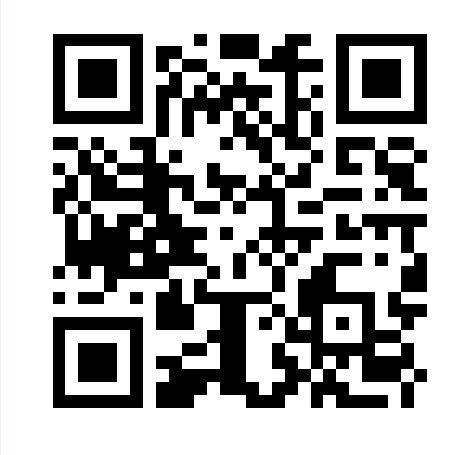
